# 회귀 분석을 활용한 주택 가격 예측

In [1]:
!pip install lightgbm==3.3.5


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. 라이브러리 및 데이터 불러오기

In [2]:
#평균 제곱 오차를 활용해 정확도 평가 - 로그를 취해야 예측 값 간 찿이 작아져 정확도 높아짐
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import random
np.random.seed(1234) #랜덤 시드 설정
random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 벤치마크용 베이스라인

In [3]:
#최소한의 전처리 후 lightGBM 예측
#print(train_df.dtypes,"\n")
#print(train_df["MSZoning"].value_counts()) #판매처 용도의 분류

#학습 데이터, 테스트 데이터 합해서 전처리
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df["SalePrice"] #학습 데이터는 있고, 테스트 데이터는 NaN

#카테고리 변수를 수치로 변환하기
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes=="object"]
#print(categories)
all_df["Alley"].value_counts()

#결측치를 수치로 변환하기
for cat in categories:
    le = LabelEncoder()
    #print(cat)

    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


https://aldente0630.github.io/data-science/2018/06/29/highly-efficient-gbdt.html

In [4]:
#학습 데이터와 테스트 데이터로 되돌리기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

import lightgbm as lgb #그래디언트 부스팅 결정 트리 - 4.0.0보다 낮아야 함
from sklearn.model_selection import KFold #교차 검증
folds=3
kf = KFold(n_splits=folds)
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}
#설명 변수, 목적 변수 지정
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1) #설명변수
train_Y = train_df_le["SalePrice"] #목적변수

from sklearn.metrics import mean_squared_error #평균 제곱 오차
from platform import python_version

print(python_version())
#모델 별 예측값 저장하기
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),],
                          verbose_eval=10
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

3.10.10
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape   
487           20        3         70.0    12243      1     2        0  \
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence   
487            3         0         4

In [5]:
#평균 RMSE 계산하기
sum(rmses)/len(rmses)

0.1352849504777467

<Axes: >

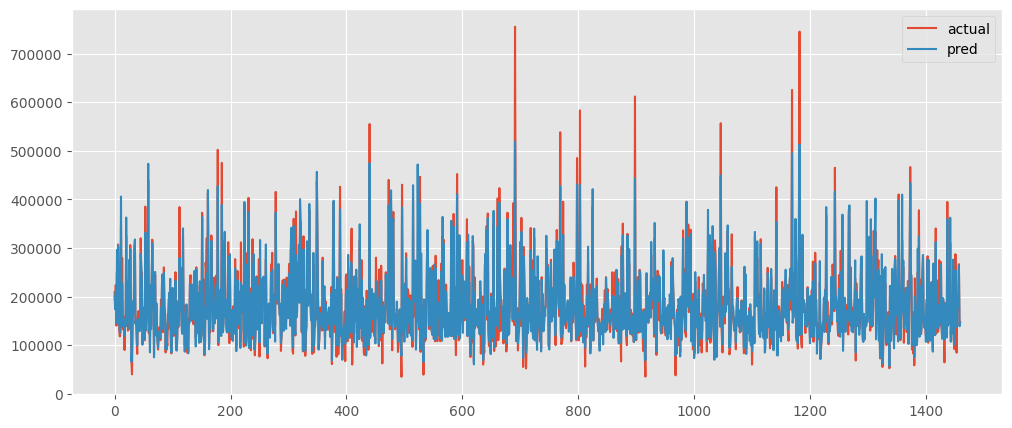

In [6]:
#현재 예측 값과 실제 값 차이 확인
actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof})
actual_pred_df.plot(figsize=(12,5))

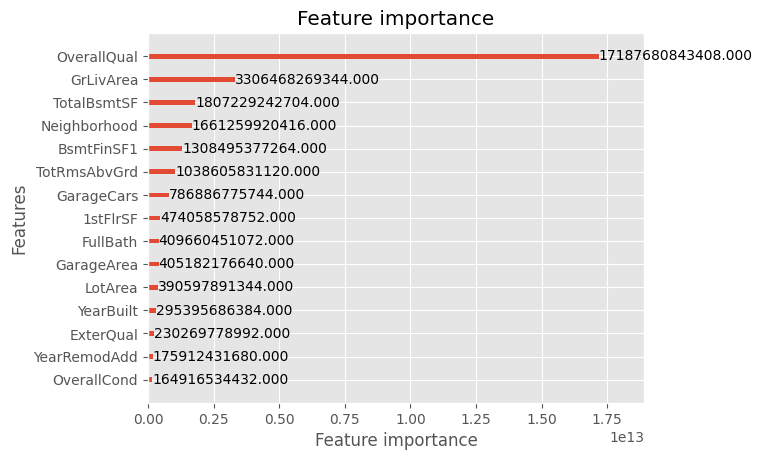

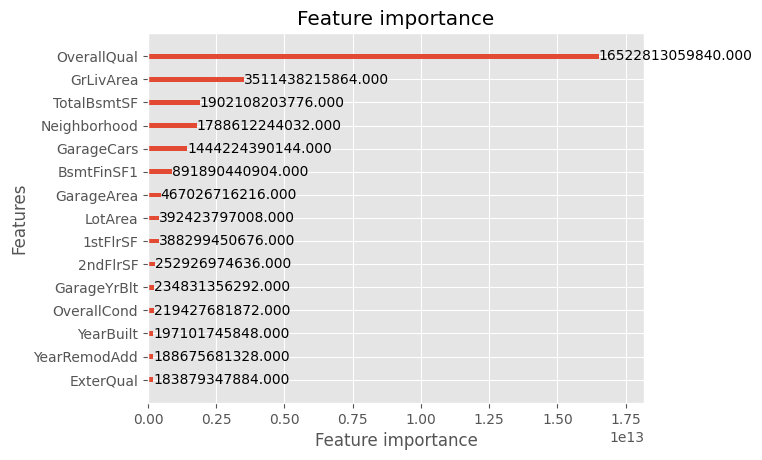

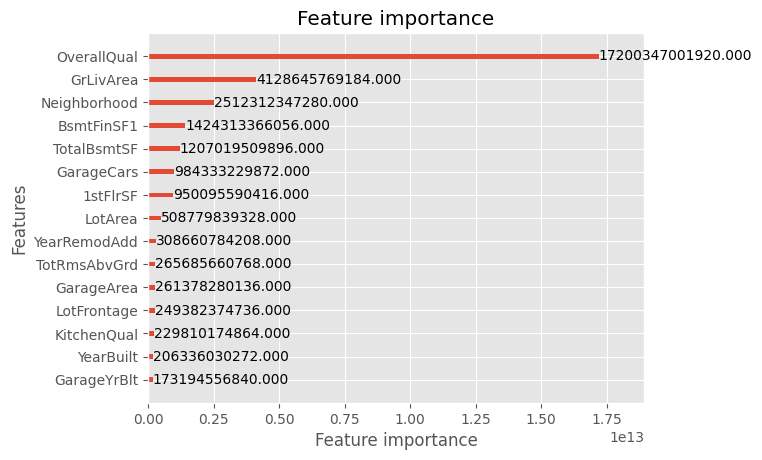

In [7]:
#각 변수의 중요도 확인 - 주택 전체의 재료와 마감 등 퀄리티, 주거 영역 크기
for model in models:
    lgb.plot_importance(model, importance_type ="gain", max_num_features=15)

## 3. 목적 변수의 전처리 : 목적 변수의 분포 확인

In [8]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

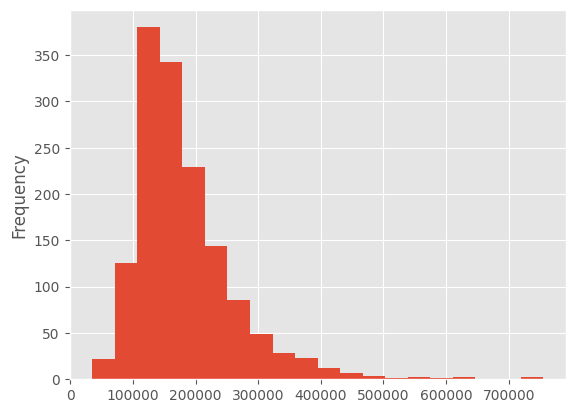

In [9]:
train_df["SalePrice"].plot.hist(bins=20) #비대칭(왼쪽으로 치우침) - 푸아송 분포

In [10]:
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<Axes: ylabel='Frequency'>

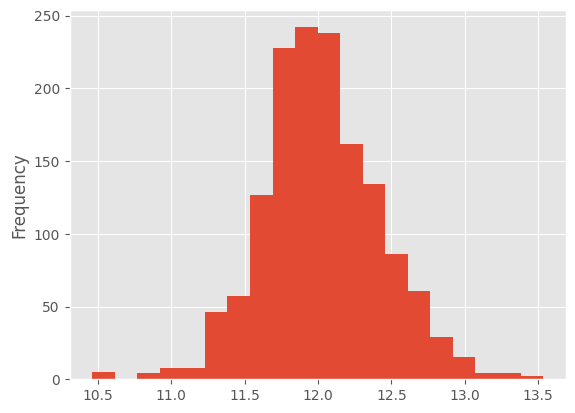

In [11]:
np.log(train_df['SalePrice']).plot.hist(bins=20) #정규분포와 비슷하게

In [12]:
pd.options.mode.chained_assignment=None #목적 변수 로그화
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [13]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0222385
[30]	valid_0's l2: 0.0180434
[40]	valid_0's l2: 0.016907
[50]	valid_0's l2: 0.0165714
[60]	valid_0's l2: 0.0163693
[70]	valid_0's l2: 0.0162283
[80]	valid_0's l2: 0.0161985
[90]	valid_0's l2: 0.0160713
[100]	valid_0's l2: 0.0161346
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 0.0160713
0.12677276183461025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM

In [14]:
sum(rmses)/len(rmses) #값 낮아짐 -> 즉 정확도 소폭 높아짐

0.13179298123488878

## 4. 설명 변수의 전처리 : 결측치 확인

In [15]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [16]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [17]:
all_df.isnull().sum().sort_values(ascending=False).head(40) #결측치 상위 40 변수
#고급 설비의 유무 관련 변수가 대부분 값이 없음

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageQual        159
GarageCond        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
Functional          2
BsmtFullBath        2
Utilities           2
BsmtHalfBath        2
Electrical          1
TotalBsmtSF         1
BsmtUnfSF           1
KitchenQual         1
BsmtFinSF2          1
BsmtFinSF1          1
SaleType            1
GarageCars          1
Exterior2nd         1
Exterior1st         1
GarageArea          1
YrSold              0
Fireplaces          0
MoSold              0
MiscVal             0
SaleCondition       0
dtype: int64

In [18]:
all_df.PoolQC.value_counts()

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

In [19]:
#값 있으면 1, 없으면 0으로 저장
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

In [20]:
all_df.PoolQC.value_counts()

PoolQC
0    2909
1      10
Name: count, dtype: int64

In [21]:
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

In [22]:
#위의 내용 한번에 처리한 코드
'''HighFacility_col = ["PoolQC","MiscFeature","Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0'''

'HighFacility_col = ["PoolQC","MiscFeature","Alley"]\nfor col in HighFacility_col:\n    if all_df[col].dtype == "object":\n        if len(all_df[all_df[col].isnull()]) > 0:\n            all_df.loc[~all_df[col].isnull(), col] = 1\n            all_df.loc[all_df[col].isnull(), col] = 0'

In [23]:
#고급 설비 개수
all_df["hasHighFacility"] = all_df["PoolQC"]+all_df["MiscFeature"] + all_df["Alley"]

In [24]:
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [25]:
all_df["hasHighFacility"].value_counts()

hasHighFacility
0    2615
1     295
2       9
Name: count, dtype: int64

In [26]:
all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

## 5. 이상치 제외

In [27]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [28]:
train_df_num = train_df.select_dtypes(include=[np.number]) #수치 데이터만 추출

In [29]:
#비례 척도가 아닌 변수
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

In [30]:
#집합 자료형으로 변환해 비례 척도인 수치 데이터만 남김
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

In [31]:
train_df_num_rs = train_df_num[num_features]

In [32]:
#다수의 데이터(75%)가 0인 변수 확인하기 (3/4분위수로 확인)
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [33]:
#특정 값만 가지는 변수 확인하기 (종류 15개 미만)
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


In [34]:
#이상치 확인 -> 평균 +- 3*표준편차
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
    (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

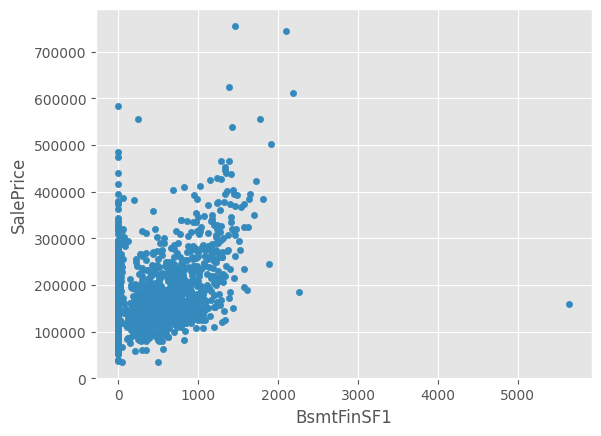

In [35]:
#이상치를 포함하는 변수의 분포 시각화
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

In [36]:
all_df[all_df["BsmtFinSF1"]>5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

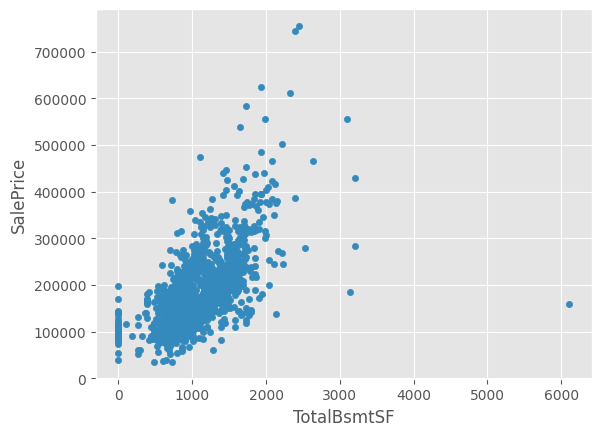

In [37]:
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [38]:
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

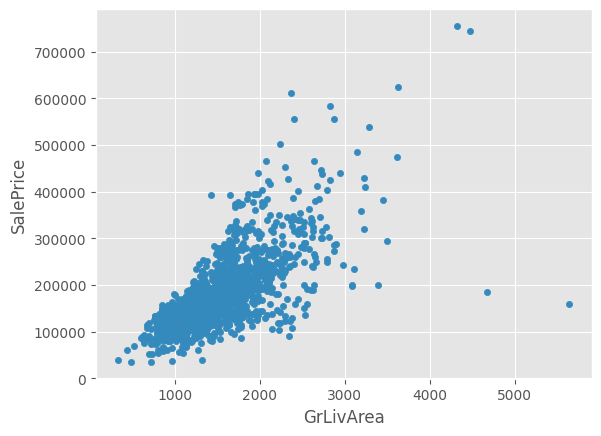

In [39]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [40]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

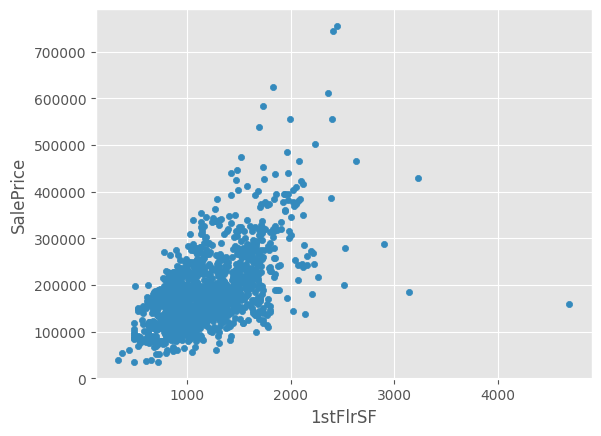

In [41]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [42]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [43]:
#이상치가 아닌 값 추출하기
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [48]:
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

KeyError: "['PoolQC', 'MiscFeature', 'Alley'] not found in axis"

In [45]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [46]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"]) #로그 변환
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [47]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0217695
[30]	valid_0's l2: 0.017511
[40]	valid_0's l2: 0.0162447
[50]	valid_0's l2: 0.0161528
[60]	valid_0's l2: 0.0160055
[70]	valid_0's l2: 0.0160335
[80]	valid_0's l2: 0.0160276
[90]	valid_0's l2: 0.0160347
[100]	valid_0's l2: 0.0160414
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0159996
0.12648953494655646
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2942
[LightGBM

In [49]:
sum(rmses)/len(rmses) #정확도 소폭 향상

0.12956644378893936

## 6. 설명 변수 확인 : 특징 값 생성

In [50]:
#시간 데이터, 넓이 데이터, 설비 및 허용 수 데이터, 품질 및 분류 데이터 등
all_df[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe() #시간 데이터

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [51]:
#건축 후 몇 년이 경과했을 때 판매되었는지
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [52]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [53]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.042401
[20]	valid_0's l2: 0.021746
[30]	valid_0's l2: 0.0174195
[40]	valid_0's l2: 0.0162542
[50]	valid_0's l2: 0.0159732
[60]	valid_0's l2: 0.0158821
[70]	valid_0's l2: 0.0158668
[80]	valid_0's l2: 0.0158347
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0158329
0.12582876406357282
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3036
[LightGBM] [Info] Number of data points in the train set: 963, number of used feat

In [54]:
sum(rmses)/len(rmses) #정확도 소폭 상승

0.12936893883978604

In [55]:
#넓이에 관한 변수 
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


In [57]:
#각 층의 전체 넓이 + 욕실 수 의 합계
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [58]:
#Porch 넓이의 합계(차 대는 곳)
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

In [59]:
#Porch 있는지 없는지 확인
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

In [60]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [61]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0383743
[20]	valid_0's l2: 0.0198815
[30]	valid_0's l2: 0.0164664
[40]	valid_0's l2: 0.0156914
[50]	valid_0's l2: 0.0154145
[60]	valid_0's l2: 0.0154487
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154024
0.12410644096766074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.

In [62]:
sum(rmses)/len(rmses) #정확도 소폭 상승

0.12715852593003876

## 7. 하이퍼파라미터 최적화

In [66]:
!pip install optuna==2.0.0

     -------------------------------------- 226.9/226.9 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 80.6/80.6 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 49.6/49.6 kB 2.6 MB/s eta 0:00:00
     -------------------------------------- 147.2/147.2 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 95.2/95.2 kB 5.3 MB/s eta 0:00:00
     -------------------------------------- 112.7/112.7 kB 6.4 MB/s eta 0:00:00
  Created wheel for optuna: filename=optuna-2.0.0-py3-none-any.whl size=312848 sha256=286e625bdc81492032e4553b224863ea3853c72920d460a987b12bf291543d4d
  Stored in directory: c:\users\gudtj\appdata\local\pip\cache\wheels\af\b0\dd\4b01b3349e2b4686297197876376cdc965339660273d5c4efc
  Created wheel for pyperclip: filen


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
#하이퍼파라미터 최적화 - Optuna
#1. 모델의 학습 흐름과 개선하려는 정확도 정의
#2. 조정하고자 하는 모델의 하이퍼파라미터 및 탐색 범위 설정
#3. 실행 횟수 정하여 최적화 실행
import optuna
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [67]:
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05, #앞서 실행한 학습을 다음 학습에 반영할 비율       
        "n_estimators":1000,  #학습 횟수
        #최적화할 하이퍼파라미터
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),        
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),                
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,)    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [68]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-10-18 22:48:17,804] A new study created in memory with name: no-name-2b92ad88-6a63-4c50-86ef-424e6c5bbf15


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659468
[20]	valid_0's l2: 0.0360287
[30]	valid_0's l2: 0.0239196
[40]	valid_0's l2: 0.0183967
[50]	valid_0's l2: 0.0161611
[60]	valid_0's l2: 0.015461
[70]	valid_0's l2: 0.0148438
[80]	valid_0's l2: 0.0145826


[I 2023-10-18 22:48:18,228] Trial 0 finished with value: 0.11921948775949834 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_fraction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.11921948775949834.


[90]	valid_0's l2: 0.0144628
[100]	valid_0's l2: 0.0143176
[110]	valid_0's l2: 0.0142316
[120]	valid_0's l2: 0.0142159
[130]	valid_0's l2: 0.0142722
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0142133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-10-18 22:48:18,686] Trial 1 finished with value: 0.12012901418633552 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_fraction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's l2: 0.0144416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-10-18 22:48:18,906] Trial 2 finished with value: 0.12243462195761393 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_fraction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0723969
[20]	valid_0's l2: 0.0430363
[30]	valid_0's l2: 0.0303053
[40]	valid_0's l2: 0.0239242
[50]	valid_0's l2: 0.0202706
[60]	valid_0's l2: 0.0183297
[70]	valid_0's l2: 0.0171541
[80]	valid_0's l2: 0.0162883
[90]	valid_0's l2: 0.0158127
[100]	valid_0's l2: 0.0154521
[110]	valid_0's l2: 0.0149976
[120]	valid_0's l2: 0.0150278
[130]	valid_0's l2: 0.0150877
Early stopping, best iteration is:
[113]	valid_0's l2: 0.0149902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remo

[I 2023-10-18 22:48:19,577] Trial 3 finished with value: 0.11948763685441077 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.


[140]	valid_0's l2: 0.0143614
[150]	valid_0's l2: 0.014341
[160]	valid_0's l2: 0.0143097
[170]	valid_0's l2: 0.0143001
Early stopping, best iteration is:
[157]	valid_0's l2: 0.0142773
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066408
[20]	valid_0's l2: 0.0363539
[30]	valid_0's l2: 0.0242351
[40]	valid_0's l2: 0.0189323
[50]	valid_0's l2: 0.0162179
[60]	valid_0's l2: 0.0147991
[70]	valid_0's l2: 0.0143232
[80]	valid_0's l2: 0.0143152
[90]	valid_0's l2: 0.0142693
[100]	valid_0's l2: 0.0140259
[110]	valid_0's l2: 0.0140546
[120]	valid_0's l2: 0.0138189
[130]	valid_0's l2: 0.0137193
[140]	valid_0's l2: 0.0137243


[I 2023-10-18 22:48:20,109] Trial 4 finished with value: 0.11621335807143585 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_fraction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0639992
[20]	valid_0's l2: 0.0357102
[30]	valid_0's l2: 0.0236082
[40]	valid_0's l2: 0.0186928
[50]	valid_0's l2: 0.016742
[60]	valid_0's l2: 0.0157799
[70]	valid_0's l2: 0.0155055


[I 2023-10-18 22:48:20,521] Trial 5 finished with value: 0.12288551018586134 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_fraction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


[80]	valid_0's l2: 0.0152684
[90]	valid_0's l2: 0.0151588
[100]	valid_0's l2: 0.0151961
[110]	valid_0's l2: 0.0152685
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0151008
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650692
[20]	valid_0's l2: 0.035213
[30]	valid_0's l2: 0.0235695
[40]	valid_0's l2: 0.0189368
[50]	valid_0's l2: 0.0171787
[60]	valid_0's l2: 0.0162984
[70]	valid_0's l2: 0.0160839
[80]	valid_0's l2: 0.0159674
[90]	valid_0's l2: 0.0157391
[100]	valid_0's l2: 0.0156661
[110]	valid_0's l2: 0.015579
[120]	valid_0's l2: 0.0154832
[130]	valid_0's l2: 0.0153392
[140]	valid_0's l2: 0.0153525


[I 2023-10-18 22:48:21,165] Trial 6 finished with value: 0.12372288602804948 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_fraction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[150]	valid_0's l2: 0.0153259
[160]	valid_0's l2: 0.0153393
[170]	valid_0's l2: 0.015381
Early stopping, best iteration is:
[152]	valid_0's l2: 0.0153074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0685588
[20]	valid_0's l2: 0.0385705
[30]	valid_0's l2: 0.0262354
[40]	valid_0's l2: 0.0206248
[50]	valid_0's l2: 0.017847
[60]	valid_0's l2: 0.0167885
[70]	valid_0's l2: 0.0160365
[80]	valid_0's l2: 0.0157248
[90]	valid_0's l2: 0.0156422
[100]	valid_0's l2: 0.0155114
[110]	valid_0's l2: 0.0154175
[120]	valid_0's l2: 0.015317
[130]	valid_0's l2: 0.0151995


[I 2023-10-18 22:48:21,563] Trial 7 finished with value: 0.12325661836479342 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[140]	valid_0's l2: 0.0152626
[150]	valid_0's l2: 0.0152446
Early stopping, best iteration is:
[134]	valid_0's l2: 0.0151922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653917
[20]	valid_0's l2: 0.0353138
[30]	valid_0's l2: 0.0236292
[40]	valid_0's l2: 0.0191997
[50]	valid_0's l2: 0.0170269
[60]	valid_0's l2: 0.0159562
[70]	valid_0's l2: 0.015702
[80]	valid_0's l2: 0.0155463
[90]	valid_0's l2: 0.0154414
[100]	valid_0's l2: 0.0153966
[110]	valid_0's l2: 0.0153345
[120]	valid_0's l2: 0.0152618
[130]	valid_0's l2: 0.015293
[140]	valid_0's l2: 0.0152435
[150]	valid_0's l2: 0.0152064
[160]	valid_0's l2: 0.0151995


[I 2023-10-18 22:48:22,180] Trial 8 finished with value: 0.123200368396042 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_fraction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0720131
[20]	valid_0's l2: 0.0421651
[30]	valid_0's l2: 0.0286681
[40]	valid_0's l2: 0.0219793
[50]	valid_0's l2: 0.0183408
[60]	valid_0's l2: 0.0164611
[70]	valid_0's l2: 0.01556
[80]	valid_0's l2: 0.015073
[90]	valid_0's l2: 0.0147495
[100]	valid_0's l2: 0.0145849
[110]	valid_0's l2: 0.0144036
[120]	valid_0's l2: 0.014341
[130]	valid_0's l2: 0.0143924
[140]	valid_0's l2: 0.0141699
[150]	valid_0's l2: 0.014075
[160]	valid_0's l2: 0.0140656


[I 2023-10-18 22:48:22,487] Trial 9 finished with value: 0.11833589511118965 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_fraction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[170]	valid_0's l2: 0.0140668
[180]	valid_0's l2: 0.0140637
Early stopping, best iteration is:
[164]	valid_0's l2: 0.0140034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0645947
[20]	valid_0's l2: 0.0349
[30]	valid_0's l2: 0.0239167
[40]	valid_0's l2: 0.019325
[50]	valid_0's l2: 0.017922
[60]	valid_0's l2: 0.017351
[70]	valid_0's l2: 0.0171303
[80]	valid_0's l2: 0.0171538
[90]	valid_0's l2: 0.0170625
[100]	valid_0's l2: 0.0169556
[110]	valid_0's l2: 0.0169456
[120]	valid_0's l2: 0.0168885
[130]	valid_0's l2: 0.0168479
[140]	valid_0's l2: 0.0168025
[150]	valid_0's l2: 0.0167815
[160]	valid_0's l2: 0.0168289
[170

[I 2023-10-18 22:48:23,333] Trial 10 finished with value: 0.1295435415929816 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_fraction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0723296
[20]	valid_0's l2: 0.0424445
[30]	valid_0's l2: 0.0284022
[40]	valid_0's l2: 0.0222346
[50]	valid_0's l2: 0.0189382
[60]	valid_0's l2: 0.0171733
[70]	valid_0's l2: 0.0163607
[80]	valid_0's l2: 0.0154663
[90]	valid_0's l2: 0.0151567
[100]	valid_0's l2: 0.0149257
[110]	valid_0's l2: 0.0147376
[120]	valid_0's l2: 0.0145206
[130]	valid_0's l2: 0.0145659
[140]	valid_0's l2: 0.0145321
[150]	valid_0's l2: 0.0144151
[160]	valid_0's l2: 0.014383
[170]	valid_0's l2: 0.0144667


[I 2023-10-18 22:48:23,643] Trial 11 finished with value: 0.11992918918638319 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_fraction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[180]	valid_0's l2: 0.0144939
Early stopping, best iteration is:
[160]	valid_0's l2: 0.014383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0652096
[20]	valid_0's l2: 0.0355787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's l2: 0.0236788
[40]	valid_0's l2: 0.0185916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	vali

[I 2023-10-18 22:48:24,069] Trial 12 finished with value: 0.12066129587078789 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_fraction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


Early stopping, best iteration is:
[92]	valid_0's l2: 0.0145591
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0675109
[20]	valid_0's l2: 0.0373061
[30]	valid_0's l2: 0.0244711
[40]	valid_0's l2: 0.0192189
[50]	valid_0's l2: 0.0169365
[60]	valid_0's l2: 0.015945
[70]	valid_0's l2: 0.0153745
[80]	valid_0's l2: 0.0150851
[90]	valid_0's l2: 0.014887
[100]	valid_0's l2: 0.0147742
[110]	valid_0's l2: 0.0146256
[120]	valid_0's l2: 0.0146666
[130]	valid_0's l2: 0.0145984
[140]	valid_0's l2: 0.014508
[150]	valid_0's l2: 0.0144821
[160]	valid_0's l2: 0.0144311
[170]	valid_0's l2: 0.014398
[180]	valid_0's l2: 0.0144176
[19

[I 2023-10-18 22:48:24,716] Trial 13 finished with value: 0.1199504383453797 and parameters: {'num_leaves': 44, 'max_bin': 69, 'bagging_fraction': 0.7581636020592828, 'bagging_freq': 3, 'feature_fraction': 0.49159568100355844, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-10-18 22:48:25,222] Trial 14 finished with value: 0.1183866598579404 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_fraction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652192
[20]	valid_0's l2: 0.0356203
[30]	valid_0's l2: 0.023876
[40]	valid_0's l2: 0.0188538
[50]	valid_0's l2: 0.0170089
[60]	valid_0's l2: 0.0161279
[70]	valid_0's l2: 0.0157713
[80]	valid_0's l2: 0.0154205
[90]	valid_0's l2: 0.0153315
[100]	valid_0's l2: 0.0151689
[110]	valid_0's l2: 0.0150059
[120]	valid_0's l2: 0.0150484
[130]	valid_0's l2: 0.0150938
Early stopping, best iteration is:
[110]	valid_0's l2: 0.0150059


[I 2023-10-18 22:48:25,719] Trial 15 finished with value: 0.12249843914982214 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0654476
[20]	valid_0's l2: 0.0348945
[30]	valid_0's l2: 0.0232133
[40]	valid_0's l2: 0.0186158
[50]	valid_0's l2: 0.0167928
[60]	valid_0's l2: 0.0158671
[70]	valid_0's l2: 0.0151884
[80]	valid_0's l2: 0.014973
[90]	valid_0's l2: 0.0148574
[100]	valid_0's l2: 0.0147908
[110]	valid_0's l2: 0.0147467
[120]	valid_0's l2: 0.0147442


[I 2023-10-18 22:48:26,361] Trial 16 finished with value: 0.12079833209560319 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_fraction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[130]	valid_0's l2: 0.0147911
[140]	valid_0's l2: 0.0146097
[150]	valid_0's l2: 0.0146298
[160]	valid_0's l2: 0.0146584
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0145922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0635115
[20]	valid_0's l2: 0.0356727
[30]	valid_0's l2: 0.0241828
[40]	valid_0's l2: 0.0197761
[50]	valid_0's l2: 0.017458
[60]	valid_0's l2: 0.0164014


[I 2023-10-18 22:48:26,828] Trial 17 finished with value: 0.12465732708852482 and parameters: {'num_leaves': 46, 'max_bin': 159, 'bagging_fraction': 0.6506621909633512, 'bagging_freq': 10, 'feature_fraction': 0.7219950996148188, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[70]	valid_0's l2: 0.0161523
[80]	valid_0's l2: 0.015674
[90]	valid_0's l2: 0.0155865
[100]	valid_0's l2: 0.0156389
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0155394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0772015
[20]	valid_0's l2: 0.0488641
[30]	valid_0's l2: 0.034581
[40]	valid_0's l2: 0.0270809
[50]	valid_0's l2: 0.0230393
[60]	valid_0's l2: 0.020913
[70]	valid_0's l2: 0.0198276
[80]	valid_0's l2: 0.018913
[90]	valid_0's l2: 0.0180636
[100]	valid_0's l2: 0.0173222
[110]	valid_0's l2: 0.0167365
[120]	valid_0's l2: 0.0162763
[130]	valid_0's l2: 0.016011
[140]	valid_0's l2: 0.0157394
[150]	v

[I 2023-10-18 22:48:27,164] Trial 18 finished with value: 0.11966528057480719 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_fraction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[300]	valid_0's l2: 0.0143803
Early stopping, best iteration is:
[282]	valid_0's l2: 0.0143198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0666045
[20]	valid_0's l2: 0.037398
[30]	valid_0's l2: 0.0252309
[40]	valid_0's l2: 0.0194101
[50]	valid_0's l2: 0.016904
[60]	valid_0's l2: 0.0160305
[70]	valid_0's l2: 0.0153439
[80]	valid_0's l2: 0.0148304
[90]	valid_0's l2: 0.0147109
[100]	valid_0's l2: 0.0145076
[110]	valid_0's l2: 0.0145036
[120]	valid_0's l2: 0.0144584
[130]	valid_0's l2: 0.0144166
[140]	valid_0's l2: 0.0145413


[I 2023-10-18 22:48:27,578] Trial 19 finished with value: 0.12002938223871082 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


[150]	valid_0's l2: 0.0145218
Early stopping, best iteration is:
[131]	valid_0's l2: 0.014407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2023-10-18 22:48:28,071] Trial 20 finished with value: 0.12442620993318665 and parameters: {'num_leaves': 58, 'max_bin': 105, 'bagging_fraction': 0.6179324626328134, 'bagging_freq': 9, 'feature_fraction': 0.8030969945230428, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's l2: 0.0155335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-10-18 22:48:28,847] Trial 21 finished with value: 0.12718774119423695 and parameters: {'num_leaves': 60, 'max_bin': 157, 'bagging_fraction': 0.8994235032839333, 'bagging_freq': 2, 'feature_fraction': 0.8340630286841071, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0717053
[20]	valid_0's l2: 0.0413166
[30]	valid_0's l2: 0.0279717
[40]	valid_0's l2: 0.0219095
[50]	valid_0's l2: 0.0189611
[60]	valid_0's l2: 0.0172604
[70]	valid_0's l2: 0.0164715
[80]	valid_0's l2: 0.0160482
[90]	valid_0's l2: 0.0157468
[100]	valid_0's l2: 0.0153786
[110]	valid_0's l2: 0.0151728
[120]	valid_0's l2: 0.0149921
[130]	valid_0's l2: 0.0149268


[I 2023-10-18 22:48:29,214] Trial 22 finished with value: 0.12151261222488925 and parameters: {'num_leaves': 11, 'max_bin': 178, 'bagging_fraction': 0.8036594793625054, 'bagging_freq': 6, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[140]	valid_0's l2: 0.0148403
[150]	valid_0's l2: 0.0148404
Early stopping, best iteration is:
[137]	valid_0's l2: 0.0147653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0656779
[20]	valid_0's l2: 0.0362675
[30]	valid_0's l2: 0.0243702
[40]	valid_0's l2: 0.019556
[50]	valid_0's l2: 0.0175464
[60]	valid_0's l2: 0.0166221
[70]	valid_0's l2: 0.016172
[80]	valid_0's l2: 0.0160095
[90]	valid_0's l2: 0.015721
[100]	valid_0's l2: 0.0155644
[110]	valid_0's l2: 0.0154965
[120]	valid_0's l2: 0.0154206
[130]	valid_0's l2: 0.0153846
[140]	valid_0's l2: 0.0154011
[150]	valid_0's l2: 0.0152218
[160]	valid_0's l2: 0.0151882
[

[I 2023-10-18 22:48:29,980] Trial 23 finished with value: 0.12286137283920079 and parameters: {'num_leaves': 31, 'max_bin': 159, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_fraction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[180]	valid_0's l2: 0.0151587
[190]	valid_0's l2: 0.0151501
[200]	valid_0's l2: 0.0151077
[210]	valid_0's l2: 0.0151401
[220]	valid_0's l2: 0.0151285
[230]	valid_0's l2: 0.015138
Early stopping, best iteration is:
[214]	valid_0's l2: 0.0150949
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0666495
[20]	valid_0's l2: 0.0366255
[30]	valid_0's l2: 0.0251371
[40]	valid_0's l2: 0.0201572
[50]	valid_0's l2: 0.0179482
[60]	valid_0's l2: 0.0167342
[70]	valid_0's l2: 0.0163499
[80]	valid_0's l2: 0.0159761
[90]	valid_0's l2: 0.0157986
[100]	valid_0's l2: 0.0158269
[110]	valid_0's l2: 0.015862
Early stopping, best iteration

[I 2023-10-18 22:48:30,461] Trial 24 finished with value: 0.12562753706931873 and parameters: {'num_leaves': 48, 'max_bin': 75, 'bagging_fraction': 0.6605183031020647, 'bagging_freq': 1, 'feature_fraction': 0.49999826244820006, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0688781
[20]	valid_0's l2: 0.0382244
[30]	valid_0's l2: 0.0256253
[40]	valid_0's l2: 0.0200546
[50]	valid_0's l2: 0.0173239
[60]	valid_0's l2: 0.0160902
[70]	valid_0's l2: 0.0154621
[80]	valid_0's l2: 0.0150493
[90]	valid_0's l2: 0.0148306
[100]	valid_0's l2: 0.0145364
[110]	valid_0's l2: 0.0144797
[120]	valid_0's l2: 0.0143889
[130]	valid_0's l2: 0.0142687
[140]	valid_0's l2: 0.0141614
[150]	valid_0's l2: 0.0140351
[160]	valid_0's l2: 0.0139486
[170]	valid_0's l2: 0.0139869
[180]	valid_0's l2: 0.0139826
[190]	valid_0's l2: 0.014061
Early stopping, best iteration is:

[I 2023-10-18 22:48:30,921] Trial 25 finished with value: 0.11805245762386342 and parameters: {'num_leaves': 17, 'max_bin': 102, 'bagging_fraction': 0.8640406467327955, 'bagging_freq': 8, 'feature_fraction': 0.41591946476565395, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0648772
[20]	valid_0's l2: 0.0348522
[30]	valid_0's l2: 0.0229095
[40]	valid_0's l2: 0.0183481
[50]	valid_0's l2: 0.0164278
[60]	valid_0's l2: 0.0157691


[I 2023-10-18 22:48:31,324] Trial 26 finished with value: 0.1225406887451526 and parameters: {'num_leaves': 39, 'max_bin': 85, 'bagging_fraction': 0.867106998962397, 'bagging_freq': 7, 'feature_fraction': 0.6678164015124792, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143585.


[70]	valid_0's l2: 0.0153027
[80]	valid_0's l2: 0.0150543
[90]	valid_0's l2: 0.0150916
[100]	valid_0's l2: 0.0152523
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0150162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066821
[20]	valid_0's l2: 0.0369266
[30]	valid_0's l2: 0.024767
[40]	valid_0's l2: 0.0192622
[50]	valid_0's l2: 0.0169376
[60]	valid_0's l2: 0.0157414
[70]	valid_0's l2: 0.0150072
[80]	valid_0's l2: 0.0146723
[90]	valid_0's l2: 0.0143443
[100]	valid_0's l2: 0.0143655
[110]	valid_0's l2: 0.0142893


[I 2023-10-18 22:48:31,658] Trial 27 finished with value: 0.11930966687202046 and parameters: {'num_leaves': 23, 'max_bin': 110, 'bagging_fraction': 0.5049218744875611, 'bagging_freq': 2, 'feature_fraction': 0.8721861949919668, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


Early stopping, best iteration is:
[95]	valid_0's l2: 0.0142348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0689996
[20]	valid_0's l2: 0.0393946
[30]	valid_0's l2: 0.026756
[40]	valid_0's l2: 0.0207262
[50]	valid_0's l2: 0.0181382


[I 2023-10-18 22:48:31,960] Trial 28 finished with value: 0.119057350011904 and parameters: {'num_leaves': 17, 'max_bin': 88, 'bagging_fraction': 0.42901458016193783, 'bagging_freq': 5, 'feature_fraction': 0.5558979409970513, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[60]	valid_0's l2: 0.0163805
[70]	valid_0's l2: 0.0155477
[80]	valid_0's l2: 0.0151918
[90]	valid_0's l2: 0.0149329
[100]	valid_0's l2: 0.0144812
[110]	valid_0's l2: 0.0143082
[120]	valid_0's l2: 0.0142451
[130]	valid_0's l2: 0.0142627
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0141747
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0686203
[20]	valid_0's l2: 0.0388643
[30]	valid_0's l2: 0.0264241
[40]	valid_0's l2: 0.0202205
[50]	valid_0's l2: 0.0174781
[60]	valid_0's l2: 0.015947
[70]	valid_0's l2: 0.0152872
[80]	valid_0's l2: 0.0148317
[90]	valid_0's l2: 0.0145008
[100]	valid_0's l2: 0.01441
[110]

[I 2023-10-18 22:48:32,230] Trial 29 finished with value: 0.1168966718905799 and parameters: {'num_leaves': 14, 'max_bin': 53, 'bagging_fraction': 0.4336248157316243, 'bagging_freq': 7, 'feature_fraction': 0.6268484222780226, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-10-18 22:48:32,913] Trial 30 finished with value: 0.11621005960781597 and parameters: {'num_leaves': 64, 'max_bin': 82, 'bagging_fraction': 0.7315391015500504, 'bagging_freq': 3, 'feature_fraction': 0.41032549973286436, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0662191
[20]	valid_0's l2: 0.0375317
[30]	valid_0's l2: 0.0249813
[40]	valid_0's l2: 0.0196436
[50]	valid_0's l2: 0.0175243
[60]	valid_0's l2: 0.016674
[70]	valid_0's l2: 0.0161567
[80]	valid_0's l2: 0.0160406
[90]	valid_0's l2: 0.0159134
[100]	valid_0's l2: 0.0157352
[110]	valid_0's l2: 0.0156062
[120]	valid_0's l2: 0.0154926
[130]	valid_0's l2: 0.0153928
[140]	valid_0's l2: 0.015358
[150]	valid_0's l2: 0.0152489
[160]	valid_0's l2: 0.0153489
[170]	valid_0's l2: 0.0153372
Early stopping, best iteration is:
[154]	valid_0's l2: 0.0152423


[I 2023-10-18 22:48:33,390] Trial 31 finished with value: 0.12345973724558293 and parameters: {'num_leaves': 27, 'max_bin': 138, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_fraction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0687108
[20]	valid_0's l2: 0.039362
[30]	valid_0's l2: 0.0268704
[40]	valid_0's l2: 0.0213277
[50]	valid_0's l2: 0.0185501
[60]	valid_0's l2: 0.0172349
[70]	valid_0's l2: 0.0165869
[80]	valid_0's l2: 0.0160938
[90]	valid_0's l2: 0.016112
[100]	valid_0's l2: 0.0158469
[110]	valid_0's l2: 0.0156173
[120]	valid_0's l2: 0.0155477


[I 2023-10-18 22:48:33,750] Trial 32 finished with value: 0.12450060870067971 and parameters: {'num_leaves': 15, 'max_bin': 193, 'bagging_fraction': 0.7437441381939076, 'bagging_freq': 3, 'feature_fraction': 0.8736852952444621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 30 with value: 0.11621005960781597.


[130]	valid_0's l2: 0.01557
[140]	valid_0's l2: 0.0155486
[150]	valid_0's l2: 0.0155581
[160]	valid_0's l2: 0.0155437
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0155004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0682726
[20]	valid_0's l2: 0.0384307
[30]	valid_0's l2: 0.0260289
[40]	valid_0's l2: 0.0204018
[50]	valid_0's l2: 0.0177781
[60]	valid_0's l2: 0.0165407
[70]	valid_0's l2: 0.0158151
[80]	valid_0's l2: 0.0154962
[90]	valid_0's l2: 0.0152292
[100]	valid_0's l2: 0.0150404
[110]	valid_0's l2: 0.0148178
[120]	valid_0's l2: 0.0148236
[130]	valid_0's l2: 0.0146665
[140]	valid_0's l2: 0.0146263


[I 2023-10-18 22:48:34,105] Trial 33 finished with value: 0.1207198568553516 and parameters: {'num_leaves': 17, 'max_bin': 128, 'bagging_fraction': 0.4128313590272658, 'bagging_freq': 3, 'feature_fraction': 0.6123427343757532, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 30 with value: 0.11621005960781597.


Early stopping, best iteration is:
[153]	valid_0's l2: 0.0145733
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676655
[20]	valid_0's l2: 0.0383163
[30]	valid_0's l2: 0.0259987
[40]	valid_0's l2: 0.0205822
[50]	valid_0's l2: 0.0179582
[60]	valid_0's l2: 0.0165008
[70]	valid_0's l2: 0.0159439
[80]	valid_0's l2: 0.0154322
[90]	valid_0's l2: 0.0152
[100]	valid_0's l2: 0.0150601
[110]	valid_0's l2: 0.0149015
[120]	valid_0's l2: 0.0147122
[130]	valid_0's l2: 0.0146916
[140]	valid_0's l2: 0.0146432
[150]	valid_0's l2: 0.0145681
[160]	valid_0's l2: 0.014555


[I 2023-10-18 22:48:34,606] Trial 34 finished with value: 0.1203595765461759 and parameters: {'num_leaves': 20, 'max_bin': 138, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 2, 'feature_fraction': 0.6586895535770572, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[170]	valid_0's l2: 0.0145766
[180]	valid_0's l2: 0.0145195
[190]	valid_0's l2: 0.0145071
[200]	valid_0's l2: 0.0145429
Early stopping, best iteration is:
[186]	valid_0's l2: 0.0144864
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.068393
[20]	valid_0's l2: 0.0381795
[30]	valid_0's l2: 0.0252867
[40]	valid_0's l2: 0.0199694
[50]	valid_0's l2: 0.017562
[60]	valid_0's l2: 0.0163758
[70]	valid_0's l2: 0.0155249
[80]	valid_0's l2: 0.0149318
[90]	valid_0's l2: 0.0147414


[I 2023-10-18 22:48:35,001] Trial 35 finished with value: 0.12059170214927306 and parameters: {'num_leaves': 28, 'max_bin': 135, 'bagging_fraction': 0.49163991810703933, 'bagging_freq': 2, 'feature_fraction': 0.6440281403244773, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[100]	valid_0's l2: 0.0146293
[110]	valid_0's l2: 0.0146798
[120]	valid_0's l2: 0.0146872
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0145424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.064695
[20]	valid_0's l2: 0.0350467
[30]	valid_0's l2: 0.0236307
[40]	valid_0's l2: 0.0190976
[50]	valid_0's l2: 0.0170016
[60]	valid_0's l2: 0.0162354
[70]	valid_0's l2: 0.0158601
[80]	valid_0's l2: 0.0156705
[90]	valid_0's l2: 0.0155466
[100]	valid_0's l2: 0.0154278
[110]	valid_0's l2: 0.0153874
[120]	valid_0's l2: 0.0153315
[130]	valid_0's l2: 0.0153339
[140]	valid_0's l2: 0.0153313


[I 2023-10-18 22:48:35,655] Trial 36 finished with value: 0.12362844403791992 and parameters: {'num_leaves': 50, 'max_bin': 163, 'bagging_fraction': 0.8518598698729667, 'bagging_freq': 1, 'feature_fraction': 0.6760962349612033, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[150]	valid_0's l2: 0.0153087
[160]	valid_0's l2: 0.0153258
Early stopping, best iteration is:
[145]	valid_0's l2: 0.015284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0677306
[20]	valid_0's l2: 0.0370913
[30]	valid_0's l2: 0.0243411
[40]	valid_0's l2: 0.0191862
[50]	valid_0's l2: 0.0167617
[60]	valid_0's l2: 0.0155816
[70]	valid_0's l2: 0.0147963
[80]	valid_0's l2: 0.0142493
[90]	valid_0's l2: 0.0141046
[100]	valid_0's l2: 0.01402
[110]	valid_0's l2: 0.01378
[120]	valid_0's l2: 0.013896
[130]	valid_0's l2: 0.0137337
[140]	valid_0's l2: 0.0136708
[150]	valid_0's l2: 0.013656
[160]	valid_0's l2: 0.0135364
[170]

[I 2023-10-18 22:48:36,038] Trial 37 finished with value: 0.11634589292845095 and parameters: {'num_leaves': 21, 'max_bin': 86, 'bagging_fraction': 0.45014697113274893, 'bagging_freq': 1, 'feature_fraction': 0.8647646583960953, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[180]	valid_0's l2: 0.013646
Early stopping, best iteration is:
[160]	valid_0's l2: 0.0135364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0683957
[20]	valid_0's l2: 0.0389712
[30]	valid_0's l2: 0.0265129
[40]	valid_0's l2: 0.0206742
[50]	valid_0's l2: 0.0187495
[60]	valid_0's l2: 0.0173362


[I 2023-10-18 22:48:36,365] Trial 38 finished with value: 0.12190846996739746 and parameters: {'num_leaves': 21, 'max_bin': 138, 'bagging_fraction': 0.4319776330604906, 'bagging_freq': 5, 'feature_fraction': 0.8887475698722234, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[70]	valid_0's l2: 0.0164796
[80]	valid_0's l2: 0.0159671
[90]	valid_0's l2: 0.0157594
[100]	valid_0's l2: 0.0153507
[110]	valid_0's l2: 0.0150858
[120]	valid_0's l2: 0.014961
[130]	valid_0's l2: 0.01496
[140]	valid_0's l2: 0.0148748
[150]	valid_0's l2: 0.014995
[160]	valid_0's l2: 0.0149387
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0148617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0644176
[20]	valid_0's l2: 0.0351717
[30]	valid_0's l2: 0.0235163
[40]	valid_0's l2: 0.0193476
[50]	valid_0's l2: 0.0170961
[60]	valid_0's l2: 0.0161074
[70]	valid_0's l2: 0.0154883
[80]	valid_0's l2: 0.0152515
[90]

[I 2023-10-18 22:48:36,965] Trial 39 finished with value: 0.12215065383271784 and parameters: {'num_leaves': 62, 'max_bin': 84, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_fraction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 30 with value: 0.11621005960781597.


[140]	valid_0's l2: 0.015119
Early stopping, best iteration is:
[122]	valid_0's l2: 0.0149208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.067131
[20]	valid_0's l2: 0.037303
[30]	valid_0's l2: 0.0249732
[40]	valid_0's l2: 0.0195751
[50]	valid_0's l2: 0.0168822
[60]	valid_0's l2: 0.0154761
[70]	valid_0's l2: 0.0148505
[80]	valid_0's l2: 0.0144755
[90]	valid_0's l2: 0.014292
[100]	valid_0's l2: 0.0141133
[110]	valid_0's l2: 0.0140325
[120]	valid_0's l2: 0.0138918
[130]	valid_0's l2: 0.0138017
[140]	valid_0's l2: 0.0137878
[150]	valid_0's l2: 0.0137468
[160]	valid_0's l2: 0.0137043
[170]	valid_0's l2: 0.0137


[I 2023-10-18 22:48:37,356] Trial 40 finished with value: 0.1170233190753309 and parameters: {'num_leaves': 21, 'max_bin': 178, 'bagging_fraction': 0.7089383459587619, 'bagging_freq': 1, 'feature_fraction': 0.5736167589661099, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[180]	valid_0's l2: 0.0137556
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0136945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2424
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0680019
[20]	valid_0's l2: 0.0374251
[30]	valid_0's l2: 0.0246349
[40]	valid_0's l2: 0.019427
[50]	valid_0's l2: 0.0167085
[60]	valid_0's l2: 0.0151676
[70]	valid_0's l2: 0.014551
[80]	valid_0's l2: 0.0141983
[90]	valid_0's l2: 0.0139977
[100]	valid_0's l2: 0.0139503
[110]	valid_0's l2: 0.0138424
[120]	valid_0's l2: 0.0136913
[130]	valid_0's l2: 0.0136268
[140]	valid_0's l2: 0.0135483
[150]	valid_0's l2: 0.0134731


[I 2023-10-18 22:48:37,789] Trial 41 finished with value: 0.11607389645958345 and parameters: {'num_leaves': 33, 'max_bin': 125, 'bagging_fraction': 0.7197362581993618, 'bagging_freq': 4, 'feature_fraction': 0.4684501358427995, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958345.


[160]	valid_0's l2: 0.0135188
[170]	valid_0's l2: 0.0135685
Early stopping, best iteration is:
[150]	valid_0's l2: 0.0134731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2023-10-18 22:48:38,128] Trial 42 finished with value: 0.12360509389043547 and parameters: {'num_leaves': 35, 'max_bin': 83, 'bagging_fraction': 0.44892224224701704, 'bagging_freq': 9, 'feature_fraction': 0.8864597445115652, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958345.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664833
[20]	valid_0's l2: 0.0369944
[30]	valid_0's l2: 0.0252167
[40]	valid_0's l2: 0.0195319
[50]	valid_0's l2: 0.0176001
[60]	valid_0's l2: 0.0164878
[70]	valid_0's l2: 0.0160626
[80]	valid_0's l2: 0.0157654
[90]	valid_0's l2: 0.0154859
[100]	valid_0's l2: 0.0151975
[110]	valid_0's l2: 0.0150395


[I 2023-10-18 22:48:38,698] Trial 43 finished with value: 0.12258004859678505 and parameters: {'num_leaves': 51, 'max_bin': 100, 'bagging_fraction': 0.4405506949939984, 'bagging_freq': 5, 'feature_fraction': 0.5161170710854714, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.11607389645958345.


[120]	valid_0's l2: 0.0150358
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0150259
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0671077
[20]	valid_0's l2: 0.0359559
[30]	valid_0's l2: 0.0239904
[40]	valid_0's l2: 0.0189382
[50]	valid_0's l2: 0.0167995
[60]	valid_0's l2: 0.0154498
[70]	valid_0's l2: 0.0148961
[80]	valid_0's l2: 0.0147326
[90]	valid_0's l2: 0.0146315
[100]	valid_0's l2: 0.014387


[I 2023-10-18 22:48:39,224] Trial 44 finished with value: 0.1184374572828425 and parameters: {'num_leaves': 48, 'max_bin': 51, 'bagging_fraction': 0.7852903742513881, 'bagging_freq': 2, 'feature_fraction': 0.4397610412933779, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 41 with value: 0.11607389645958345.


[110]	valid_0's l2: 0.014218
[120]	valid_0's l2: 0.0140993
[130]	valid_0's l2: 0.0140685
[140]	valid_0's l2: 0.0140959
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0140274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676824
[20]	valid_0's l2: 0.0391645
[30]	valid_0's l2: 0.0265916
[40]	valid_0's l2: 0.0210271
[50]	valid_0's l2: 0.0183889
[60]	valid_0's l2: 0.01707
[70]	valid_0's l2: 0.0163417
[80]	valid_0's l2: 0.0159728
[90]	valid_0's l2: 0.0156951
[100]	valid_0's l2: 0.0156128
[110]	valid_0's l2: 0.0153255
[120]	valid_0's l2: 0.0152131
[130]	valid_0's l2: 0.0151542
Early stopping, best iteration 

[I 2023-10-18 22:48:39,527] Trial 45 finished with value: 0.12306701064230102 and parameters: {'num_leaves': 18, 'max_bin': 113, 'bagging_fraction': 0.6786843956619585, 'bagging_freq': 9, 'feature_fraction': 0.7635221313556642, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958345.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0736703
[20]	valid_0's l2: 0.0446699
[30]	valid_0's l2: 0.0309675
[40]	valid_0's l2: 0.0240148
[50]	valid_0's l2: 0.0205786
[60]	valid_0's l2: 0.0184582
[70]	valid_0's l2: 0.0172221
[80]	valid_0's l2: 0.0162455
[90]	valid_0's l2: 0.0157497
[100]	valid_0's l2: 0.0152315
[110]	valid_0's l2: 0.0152008
[120]	valid_0's l2: 0.0152169
[130]	valid_0's l2: 0.0149349
[140]	valid_0's l2: 0.0147038
[150]	valid_0's l2: 0.0146566
[160]	valid_0's l2: 0.0145811
[170]	valid_0's l2: 0.0146407
[180]	valid_0's l2: 0.0145551
[190]	valid_0's l2: 0.0145977
[200]	valid_0's l2: 0.0145698
Ear

[I 2023-10-18 22:48:39,787] Trial 46 finished with value: 0.12049687664013224 and parameters: {'num_leaves': 7, 'max_bin': 95, 'bagging_fraction': 0.5310590746198391, 'bagging_freq': 5, 'feature_fraction': 0.7416406677738403, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 41 with value: 0.11607389645958345.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664059
[20]	valid_0's l2: 0.0364447
[30]	valid_0's l2: 0.0245169
[40]	valid_0's l2: 0.0195329
[50]	valid_0's l2: 0.0173828
[60]	valid_0's l2: 0.0164353
[70]	valid_0's l2: 0.0157514
[80]	valid_0's l2: 0.0153623
[90]	valid_0's l2: 0.015229
[100]	valid_0's l2: 0.0151322


[I 2023-10-18 22:48:40,139] Trial 47 finished with value: 0.12172000179946446 and parameters: {'num_leaves': 27, 'max_bin': 77, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_fraction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.11607389645958345.


[110]	valid_0's l2: 0.0149309
[120]	valid_0's l2: 0.0148238
[130]	valid_0's l2: 0.0148456
[140]	valid_0's l2: 0.0148433
Early stopping, best iteration is:
[122]	valid_0's l2: 0.0148158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0674904
[20]	valid_0's l2: 0.0378495
[30]	valid_0's l2: 0.0253106
[40]	valid_0's l2: 0.0199075
[50]	valid_0's l2: 0.0172684
[60]	valid_0's l2: 0.0158523
[70]	valid_0's l2: 0.0153712
[80]	valid_0's l2: 0.0151057
[90]	valid_0's l2: 0.0150663
[100]	valid_0's l2: 0.014961
[110]	valid_0's l2: 0.0148236
[120]	valid_0's l2: 0.0147344
[130]	valid_0's l2: 0.0146849
[140]	valid_0's l2: 0.014542


[I 2023-10-18 22:48:40,540] Trial 48 finished with value: 0.12024707542561675 and parameters: {'num_leaves': 19, 'max_bin': 106, 'bagging_fraction': 0.6937998175981945, 'bagging_freq': 3, 'feature_fraction': 0.5854263996089444, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.11607389645958345.


[150]	valid_0's l2: 0.0146157
[160]	valid_0's l2: 0.0146427
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0144594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0762818
[20]	valid_0's l2: 0.0467362
[30]	valid_0's l2: 0.03249
[40]	valid_0's l2: 0.0257868
[50]	valid_0's l2: 0.0214988
[60]	valid_0's l2: 0.0193962
[70]	valid_0's l2: 0.0180176
[80]	valid_0's l2: 0.0166924


[I 2023-10-18 22:48:40,829] Trial 49 finished with value: 0.11848287385526712 and parameters: {'num_leaves': 6, 'max_bin': 170, 'bagging_fraction': 0.4384782234933164, 'bagging_freq': 6, 'feature_fraction': 0.5534050497725981, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958345.


[90]	valid_0's l2: 0.015955
[100]	valid_0's l2: 0.0155308
[110]	valid_0's l2: 0.0151824
[120]	valid_0's l2: 0.0147177
[130]	valid_0's l2: 0.0146438
[140]	valid_0's l2: 0.0145239
[150]	valid_0's l2: 0.014505
[160]	valid_0's l2: 0.0145101
[170]	valid_0's l2: 0.0143538
[180]	valid_0's l2: 0.0142652
[190]	valid_0's l2: 0.0142552
[200]	valid_0's l2: 0.0142293
[210]	valid_0's l2: 0.0140382
[220]	valid_0's l2: 0.0142292
[230]	valid_0's l2: 0.0141861
Early stopping, best iteration is:
[210]	valid_0's l2: 0.0140382


{'num_leaves': 33,
 'max_bin': 125,
 'bagging_fraction': 0.7197362581993618,
 'bagging_freq': 4,
 'feature_fraction': 0.4684501358427995,
 'min_data_in_leaf': 14,
 'min_sum_hessian_in_leaf': 2}

In [69]:
#50회 시행 중 가장 정확한 하이퍼파라미터 
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    "num_leaves":12,
    "bagging_fraction": 0.8319278029616157,
    "bagging_freq": 5,
    "feature_fraction": 0.4874544371547538,    
    "max_bin":189, 
    "min_data_in_leaf":13, 
    "min_sum_hessian_in_leaf":4
}

In [70]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 78
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0766047
[20]	valid_0's l2: 0.0422825
[30]	valid_0's l2: 0.0283687
[40]	valid_0's l2: 0.0213511
[50]	valid_0's l2: 0.0175222
[60]	valid_0's l2: 0.0156902
[70]	valid_0's l2: 0.0145307
[80]	valid_0's l2: 0.0139202
[90]	valid_0's l2: 0.0136042
[100]	valid_0's l2: 0.0133941
[110]	valid_0's l2: 0.0132972
[120]	valid_0's l2: 0.013249
[130]	valid_0's l2: 0.013225
[140]	valid_0's l2: 0.0131875
[150]	valid_0's l2: 0.0132779
Early stopping, best iteration is:
[138]	valid_0's l2: 0.0131603
0.11471830723828083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhe

In [72]:
sum(rmses)/len(rmses) #정확도 상승

0.12081654078702207

In [73]:
#테스트 데이터
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [75]:
preds = []
#예측값 계산
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [76]:
#평균 계산하여 저장
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [77]:
#로그 변환 -> 다시 원래 스케일로
preds_exp = np.exp(preds_mean)

In [78]:
len(preds_exp)

1459

In [80]:
#예측 값을 SalePrice에 저장
submission["SalePrice"] = preds_exp

In [82]:
submission.to_csv("houseprices_submit01.csv",index=False)

## 8. 앙상블

In [83]:
#랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor as rf

In [102]:
#결측치 취급 x -> 중앙값으로 대체
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

In [86]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [103]:
#결측치 중앙값으로 대체
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

In [104]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [105]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [92]:
folds=3
kf = KFold(n_splits=folds)

In [106]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13939197713830098
0.14198636310245238
0.12935625060296438


In [107]:
sum(rmses_rf)/len(rmses_rf)

0.13691153028123926

In [109]:
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [110]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [111]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [112]:
submission.to_csv("houseprices_submit02.csv",index=False)